# Logistic regression prediction threshold analysis
Analysis of one vs rest logistic regression model qulaity at different prediction threshold.

Motivation: Despite some targets having relatively low F score they also have high ROC AUC score. It was thus assessed what happens to F score when using different prediction thresholds.

In [141]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)


import pandas as pd
import numpy as np
#from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score,auc,roc_curve, precision_recall_curve
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification
import sklearn.preprocessing as pp
import altair as alt
#alt.renderers.enable('notebook')
from IPython.display import display
import matplotlib.pyplot as plt

import stages_DE.stages_library
import importlib
importlib.reload(stages_DE.stages_library)

from networks.functionsDENet import loadPickle,savePickle
from stages_DE.stages_library import PHENOTYPES, summary_classification, summary_classification_print_sort, scatter_catgory


In [17]:
proteus=True
if proteus:
    pathClassification = '/home/khrovatin/timeTrajectoriesNet/data/stages/classification/'
    dataPath= '/home/khrovatin/timeTrajectoriesNet/data/RPKUM/'
else:
    pathClassification = '/home/karin/Documents/timeTrajectories/data/stages/classification/'

## Model

Data used for modeling: samples with phenotypic annotations, excluding target tag_spore due to low number of positive samples, genes (features) that are not constant. For prediction data was split 80:20 into training and test set, accounting for class structure, and scaled to interval [0,1]. 

In [18]:
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

In [19]:
# Retain only samples with annotations
Y = conditions[(conditions[PHENOTYPES] != 0).any(axis=1)]
X = genes[Y.Measurment].T.values

In [20]:
# Remove targets with too little positive samples
order=PHENOTYPES.copy()
order.remove('tag_spore')
Y = Y[order].values

In [21]:
# Remove constant features
X=X[:,(X.std(axis=0)!=0)]

In [22]:
# Split in train and test as was done for 5-fold cross validation
X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size=0.2)

In [23]:
#Scale X features to [0,1], use X_train scaller to also scale X_test
scaler = pp.MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Classifier: One vs rest logistic regression without regularisation and class weights accounting for class imbalance. 

In [43]:
classifier = OneVsRestClassifier(estimator=LogisticRegression(n_jobs=20,  solver='saga',penalty='none',
                                                              class_weight='balanced'),
                                 n_jobs=Y_train.shape[1] ).fit(X_train,Y_train)

## Model evaluation

In [103]:
#Y_predict = classifier.predict(X_test)
Y_p = classifier.predict_proba(X_test)

In [160]:
# ROC analysis addapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#Y_score = classifier.decision_function(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#precision=dict()
#recall=dict()
#threshold=dict()
for i in range(Y_train.shape[1]):
    phenotype=order[i]
    fpr[phenotype], tpr[phenotype], _ = roc_curve(Y_test[:, i], Y_p[:, i])
    roc_auc[phenotype] = auc(fpr[phenotype], tpr[phenotype])
    #precision[phenotype],recall[phenotype],threshold[phenotype]=precision_recall_curve(Y_test[:,i],Y_p[:,i])
    

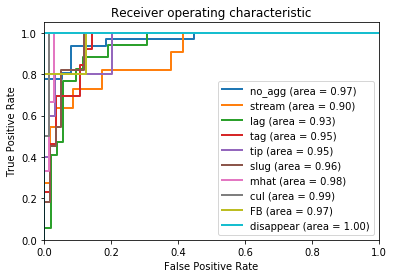

In [170]:
# ROC plot for individual targets
plt.figure()
lw = 2
colour_dict={}
for stage in order:
    p=plt.plot(fpr[stage], tpr[stage],
         lw=lw, label=stage+' (area = %0.2f)' % roc_auc[stage])
    colour_dict[stage]=p[0].get_color()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
# Calculation of precision, recall, and F score at different prediction thresholds
prfs_all=pd.DataFrame()
step=0.05
for threshold in np.arange(0, 1+step, step):
    Y_class=Y_p.copy()
    Y_class[Y_class>threshold]=1
    Y_class[Y_class<=threshold]=0
    prfs=pd.DataFrame(precision_recall_fscore_support(Y_test, Y_class),index=['precision','recall','F_score','support']).T
    prfs['Stage']=order
    prfs['Threshold']=[threshold]*prfs.shape[0]
    prfs_all=prfs_all.append(prfs)

In [174]:
# Plots of model quality metric at different prediction thresholds
display(alt.Chart(prfs_all).mark_line().encode(x='Threshold',y='F_score',
        color=alt.Color('Stage',scale=alt.Scale(domain=list(colour_dict.keys()),range=list(colour_dict.values())))))
#display(alt.Chart(prfs_all).mark_line().encode(x='Threshold',y='precision',
#        color=alt.Color('Stage',scale=alt.Scale(domain=list(colour_dict.keys()),range=list(colour_dict.values())))))
#display(alt.Chart(prfs_all).mark_line().encode(x='Threshold',y='recall',
#       color=alt.Color('Stage',scale=alt.Scale(domain=list(colour_dict.keys()),range=list(colour_dict.values())))))

alt.Chart(...)

In [ ]:
# Precision vs recall - would be better to use precision and recall caluclated when these metric change 
# (from sklearn, could be caulculated in the ROC code) instead of this one that calculates metrics based on 
# pre-defined thresholds
#display(alt.Chart(prfs_all.sort_values('recall')).mark_line().encode(x='recall',y='precision',
#        color=alt.Color('Stage',scale=alt.Scale(domain=list(colour_dict.keys()),range=list(colour_dict.values())))))

## Conclusion
For most of the targets the default prdiction threshold (0.5) seems to work fine based on F score. Exceptions are tip and slug. However, this is based on a single 'fold'/model, thus precise selection of a diffeerent threshold would require the use of more 'folds'.